In [4]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pickle

import cv2

import os
from os import listdir


In [9]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 1500

# Path to the dataset folder
root_dir = os.path.abspath('Images/')

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

In [10]:
# Return image as numpy array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [11]:
# Load categorical jpg images
# Categories based on containing folder 

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_sick ...
[INFO] Image loading completed


In [12]:
# Transform the loaded training image data into numpy array
# Note: dtype=np.uint8 is supported for images
np_image_list = np.array(image_list, dtype=np.uint8) / 225
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")


Total number of images: 3000


In [31]:
# Save binary labels to pickle file

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  2


In [15]:
# double check the image shape
np_image_list.shape

(3000, 256, 256, 3)

In [16]:
# Split the data for training
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [17]:
# Verify training split
print("Shape of X_train: ", x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of Y_test: ", y_test.shape)

Shape of X_train:  (2400, 256, 256, 3)
Shape of X_test:  (600, 256, 256, 3)
Shape of Y_train:  (2400, 1)
Shape of Y_test:  (600, 1)


369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


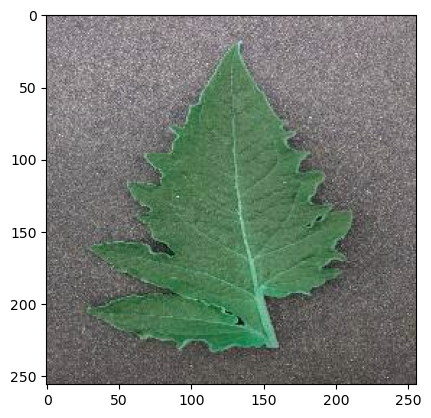

In [18]:
# Random image display - sanity check
idx = random.randint(0, len(x_test))
print(idx)

plt.imshow(x_train[idx, :])
plt.show()

In [19]:
# Prepare the model layers
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\scorp\anaconda3\envs\dev\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
# Train the model
model.fit(x_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4955 - loss: 3.1094
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8600 - loss: 0.3844
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9229 - loss: 0.1910
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9595 - loss: 0.1067
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9798 - loss: 0.0606


In [22]:
model.evaluate(x_test,y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9667 - loss: 0.1038


[0.08077874034643173, 0.9750000238418579]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


191


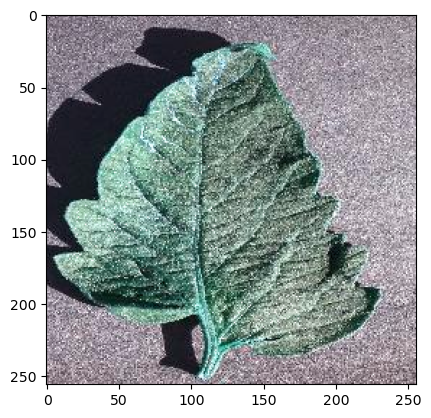

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
This leaf is  Sick


In [23]:
# Test an image prediction....
idx2 = random.randint(0, len(y_test))
print(idx2)

plt.imshow(x_train[idx2, :])
plt.show()

y_pred = model.predict(x_train[idx2, :].reshape(1,256,256,3))
y_pred = y_pred > 0.5

if(y_pred == 0):
    pred = 'Sick'
else:
    pred = 'Good'

print('This leaf is ', pred)

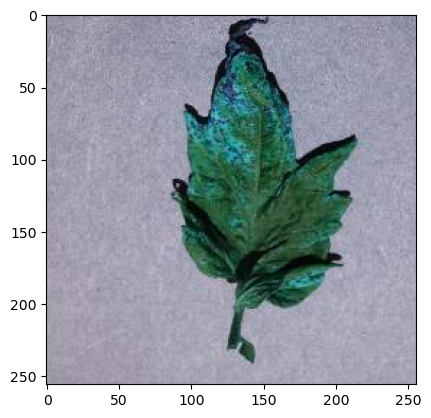

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This leaf is  Sick


In [30]:
# Load an external image to predict

# Location of your image here
img_test = ("Images/Tomato_Septoria_leaf_spot/ffe98ff9-be33-4e8f-82f0-7b7c21b02958___JR_Sept.L.S 8455.JPG")


# Convert loaded image, reshape, and predict
img_convert = convert_image_to_array(img_test)
np_image = np.array(img_convert, dtype=np.uint8) / 225.0

plt.imshow(np_image)
plt.show()

y_pred = model.predict(np_image.reshape(1,256,256,3))
y_pred = y_pred > 0.5

if(y_pred == 0):
    pred = 'Good'
else:
    pred = 'Sick'

print('This leaf is ', pred)